In [1]:
# import libaries
import matplotlib.pyplot as plt
from IPython import display
import matplotlib as mpl
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import math
import json
import numpy as np
from sqlalchemy import create_engine
import bisect
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import time
from datetime import date, timedelta

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


In [3]:
# todo:
# check update_soc variable
# check local copy of station table

# Enviorment (will be replaced with Python package later)

In [37]:
class CarsharingEnv(gym.Env):
    def __init__(self, stations, vehicle_information, soc_initial_low = 0.5, soc_initial_high=1, max_charging_power = 11, episode_len = 24, dt=0.25,
                 random_seed_number = 42, cancellation_penalty = 100, penalty_per_kwh = 0.25, v2g = True, 
                 v2g_demand_event = 500, v2g_max_duration = 3.0, v2g_penalty = 10000, 
                 v2g_probability_charging_event = 0.5, v2g_probability_discharging_event = 0.5, 
                 v2g_morning_time_period = [6.0, 9.0, 10.75], v2g_noon_time_period = [11.0, 14.0, 16.0], 
                 v2g_evening_time_period = [16.25, 19.0, 24.0], v2g_reward = 2000,
                 planned_bookings = True, precomputed_bookings = True, max_distance_car_assingment = 5000, plot_state_histogram = True, plot_state_animation = True):
        """
        Initialization of simulation environment for car-sharing charging and/or vehicle-to-grid (V2G) optimization.
        
        Parameters
        ----------
        stations: Geopandas Geodataframe
            Locations of car-sharing stations, including a distinct "station_no" attribute with station ID.
        vehicle_information: Pandas Dataframe
            Includes the features "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category" for each car.
        soc_initial_low: float, optional
            Lower bound (0-1) for initial SOC used for the reset of the environment, by default 0.5.
        soc_initial_high: float, optional
            Upper bound (0-1) for initial SOC used for the reset of the environment, by default 0.5.
        max_charging_power: int, optional
            Maximum charging power.
        episode_len: int, optional
            Length of one episode in hours, by default 24.
        dt: float, optional
            Time step size in hours, by default 0.25 (a quarter hour).
        cancellation_penalty: int, optional
            Maximum penalty in CHF for a booking cancelled due to not enough charged battery, by default 100.
        random_seed_number: int, optional
            Used for fixing random components in environment for reproducable results, by default 42.
        penalty_per_kwh: int, optional
            Penalty in CHF/kWh for total negative energy difference between beginning and ending of episode, by default 0.25.
        v2g: boolean, optional
            Boolean indicating if V2G events take place, by default True.
        v2g_demand_event: int, optional
            Energy demand during V2G event in kWh per time step (dt), by default 500.
        v2g_max_duration: int, optional
            Maximum duration of V2G charging or discharging event in hours, by default 3.
        V2G_penalty: int, optional
            Penalty in CHF if agent charges/discharges less energy than specified in "v2g_demand_event" during V2G event, by default 10000.
        v2g_probability_charging_event: float, optional
            Probability that a charging event will take place around noon, by default 0.5.
        v2g_probability_discharging_event: float, optional
            Probability that a discharging event will take place in the morning or evening, by default 0.5.
        v2g_morning_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the morning, by default 6.0 (6 AM).
                             2) last possible time (hours) for starting v2g discharging event in the morning, by default 9.0 (9 AM).
                             3) last possible timestamp for v2g discharging operation, by default 10.75 (10:45 AM).
        v2g_noon_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g charging event at noon, by default 11.0 (11 AM).
                             2) last possible time (hours) for starting v2g charging event at noon, by default 14.0 (2 PM).
                             3) last possible timestamp for v2g charging operation, by default 16.0 (4 PM).
        v2g_evening_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the evening, by default 16.25 (4:15 PM).
                             2) last possible time (hours) for starting v2g discharging event in the evening, by default 19.0 (7 PM).
                             3) last possible timestamp for v2g charging operation, by default 24 (00:00 AM, next day).
        v2g_reward: int, optional
            Revenue during v2g operations per timestep in CHF, by default 2000 CHF.
        planned_bookings: boolean, optional
            Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.
        precomputed_bookings: boolean, optional
            Boolean indicating whether the planned bookings in the environment are precomputed (for massive speed up), by default True.
        max_distance_car_assingment: int, optional
            Maximum search distance in meter for car-assingment problem, by default 5000.
        plot_state_histogram: boolean, optional
            Plot current state of enviorment as histogram or not, by default True.
        plot_state_animation: boolean, optional
            Plot current state of enviorment as animation for each car or not, by default True.
        ----------
        Observation space: 5 parts:
        1) Location for each car (four options):
            - Station number (1000-5000)
            - Reservation number (2x'xxx'xxx) during trip
            - Reservation number (3x'xxx'xxx) during relocation
            - -1 if car is not available
        2) State of charge (SOC) for each vehicle (between 0 and 1).
        3) Timestamp of the next planned booking for each car (discrete between 0 and self.episode_len).
        4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
        5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
        Remark: States 3) and 4) are only included if the variable "planned_bookings" is True.
        ----------
        Action space: 3 actions for each car:
        1) 0 = do nothing.
        2) 1 = charging.
        3) 3 = discharging (V2G).
        """
 
        # environment settings
        self.dt = dt
        self.episode_len = int(episode_len / self.dt) 
        self.planned_bookings = planned_bookings
        self.precomputed_bookings = precomputed_bookings
        self.max_distance_car_assingment = max_distance_car_assingment
        self.plot_state_histogram = plot_state_histogram
        self.plot_state_animation = plot_state_animation
        self.random_seed_number = random_seed_number
        
        # stations in system
        self.stations = stations
        
        # vehicle information
        self.vehicles_id = vehicle_information["vehicle_no"]
        self.nr_vehicles = len(self.vehicles_id)
        self.chariging_power = np.full_like(vehicle_information["charge_power"], np.minimum(vehicle_information["charge_power"], max_charging_power))
        self.battery_capacities = vehicle_information["battery_capacity"] 
        self.vehicle_type = vehicle_information["vehicle_category"] 
        self.soc_initial_low = soc_initial_low
        self.soc_initial_high = soc_initial_high
        
        # V2G 
        self.v2g = v2g
        self.v2g_demand_event = v2g_demand_event
        self.v2g_max_duration = v2g_max_duration / self.dt
        self.v2g_penalty = v2g_penalty
        self.v2g_probability_charging_event = v2g_probability_charging_event
        self.v2g_probability_discharging_event = v2g_probability_discharging_event
        self.v2g_morning_time_period = v2g_morning_time_period
        self.v2g_noon_time_period = v2g_noon_time_period
        self.v2g_evening_time_period = v2g_evening_time_period
        self.v2g_reward = v2g_reward
        
        # penalties
        self.cancellation_penalty = cancellation_penalty
        self.penalty_per_kwh = penalty_per_kwh
        
        # define observation space:
        if self.planned_bookings is True:
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0, -1, -1] * self.nr_vehicles),
                    high=np.array([9999999, 1, 96, 100] * self.nr_vehicles),
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
        else: 
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0] * self.nr_vehicles),
                    high=np.array([9999999, 1] * self.nr_vehicles)
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
    
        # define action space
        self.action_space = spaces.MultiDiscrete([3 for _ in range(self.nr_vehicles)])
        
        # define state boundaries for slicing state array
        # locations upper bound
        self.locations_upper = self.nr_vehicles
        
        # soc upper bound
        self.soc_upper = 2*self.nr_vehicles
        
        if planned_bookings is True:
            
            # planned reservations, upper bound:
            self.reservation_time_upper = self.nr_vehicles * 3
            
            # v2g, lower bound:
            self.v2g_lower = self.nr_vehicles * 4
            
        else:
            
            # v2g, lower bound:
            self.v2g_lower = self.nr_vehicles * 2
            
            
    def reset(self, daily_data, reservations, timesteps_since_start, planned_reservations = None, planned_durations = None):
        """
        Reset environment to beginning of new episode.
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.
        timesteps_since_start: int
            Timestamp since start of simulation before current day.
        planned_reservations: Pandas DataFrame, optional
            Timestamps of next planned reservations for each car, by default None.
        planned_durations: Pandas DataFrame, optional
            Durations of next planned reservations for each car, by default None.
        
        Returns
        ----------
        self.state: numpy ndarray
            The reset state of the environment at the first time step. It includes the following information for each car:
            1) Location (four options):
                - Station number (1000-5000)
                - Reservation number (2x'xxx'xxx) during trip
                - Reservation number (3x'xxx'xxx) during relocation
                - -1 if the car is not available
            2) State of charge (SOC) for each vehicle (between 0 and 1).
            3) Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
            4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
            5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
            Note: The information in 3) and 4) is included only if the variable "planned_bookings" is True.
        """
        
        # set time
        self.t = timesteps_since_start
            
        # reset reward lists 
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list_v2g = []
        self.reward_list = []
        
        # reset list with processed timestamps
        self.date_list = []
        
        # reset old state
        self.state_old = np.zeros(self.nr_vehicles * 4 + 1)
        
        # reset planned reservations:
        self.planned_reservations_car = {key: [] for key in self.vehicles_id}
        
        # get random v2g events
        self.get_random_v2g_events()
        
        # reset changes discrete table
        self.changed_vehicles = {}
        
        # reset changed reservations
        self.changed_reservations = {key: 0 for key in range(self.nr_vehicles)}

        ### initialize state for t = 0 ###
        # 1) car locations (three options)
        car_locations = daily_data.iloc[:,0 + timesteps_since_start % self.episode_len].values
        
        # 2) SOC (state of charge) ##
        rng = np.random.RandomState(self.random_seed_number)
        car_SOC = rng.uniform(low=self.soc_initial_low, high=self.soc_initial_high, size=self.nr_vehicles)
        
         # state 5) Binary V2G event
        v2g_event = np.array([0])
 
        # create final state, (add planned bookings if needed)
        if self.planned_bookings is True:
            
            # 3) timestamp of next planned reservation 
            # 4) Duration of next planned reservation
            if self.precomputed_bookings is True:
                
                # load precomputed state
                next_reservation = planned_reservations.iloc[:,0 + timesteps_since_start % self.episode_len].values
                duration_next_reservation = planned_durations.iloc[:,0 + timesteps_since_start % self.episode_len].values
                
            else:
                
                # calculate state
                next_reservation, duration_next_reservation = self.update_reservation_state(reservations, True)

            # concatinate states 1-5
            self.state = np.concatenate([car_locations, car_SOC, next_reservation, duration_next_reservation, v2g_event])
            
        else:
            
            # concatinate states 1-5 without planned boookings (state 3,4)
            self.state = np.concatenate([car_locations, car_SOC, v2g_event])
        
        # save energy at beginning of episode (for reward calculation)
        self.energy_beginning = sum(car_SOC * self.battery_capacities)

        return self.state
    
    def next_day(self, daily_data):
        """
        Loads data for simulation of new day. Does not reset the enviroment
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.
        timesteps_since_start: int
            Timestamp since start of simulation before current day.
        planned_reservations: Pandas DataFrame, optional
            Timestamps of next planned reservations for each car, by default None.
        planned_durations: Pandas DataFrame, optional
            Durations of next planned reservations for each car, by default None.
        
        Returns
        ----------
        self.state: numpy ndarray
            The reset state of the environment at the first time step. It includes the following information for each car:
            1) Location (four options):
                - Station number (1000-5000)
                - Reservation number (2x'xxx'xxx) during trip
                - Reservation number (3x'xxx'xxx) during relocation
                - -1 if the car is not available
            2) State of charge (SOC) for each vehicle (between 0 and 1).
            3) Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
            4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
            5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
            Note: The information in 3) and 4) is included only if the variable "planned_bookings" is True.
        """
        
        # assign simulation data

    
    def get_random_v2g_events(self):
        """
        Samples random V2G events during the day. A discharging event can take place in the morning and evening, a charging
        event at noon.
        """
        
        # define variables
        self.v2g_discharing_morning_start = -1
        self.v2g_discharing_morning_end = -1
        self.v2g_charing_noon_start = -1
        self.v2g_charing_noon_end = -1
        self.v2g_discharing_evening_start = -1
        self.v2g_discharing_evening_end = -1
        
        # use fixed random seed
        random.seed(self.random_seed_number)
        
        # sample random v2g event
        if self.v2g is True:
            
            # morning discharging event:
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                
                # get random start time
                self.v2g_discharing_morning_start = round(random.uniform(self.v2g_morning_time_period[0], self.v2g_morning_time_period[1]) / 0.25) * 0.25 / self.dt
                
                # get random end time
                self.v2g_discharing_morning_end = min(self.v2g_morning_time_period[2] / self.dt, self.v2g_discharing_morning_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # noon charging event
            if int(random.random() < self.v2g_probability_charging_event) == 1:
                
                # get random start time
                self.v2g_charing_noon_start = round(random.uniform(self.v2g_noon_time_period[0], self.v2g_noon_time_period[1]) / 0.25) * 0.25 / self.dt
                
                # get random end time
                self.v2g_charing_noon_end = min(self.v2g_noon_time_period[2] / self.dt, self.v2g_charing_noon_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # evening discharging event
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                
                # get random start time 
                self.v2g_discharing_evening_start = round(random.uniform(self.v2g_evening_time_period[0], self.v2g_evening_time_period[1]) / 0.25) * 0.25 / self.dt
                
                # get random end time
                self.v2g_discharing_evening_end = min(self.v2g_evening_time_period[2]/ self.dt,self.v2g_discharing_evening_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
        
        return
    
    
    def update_reservation_state(self, reservations, reset, timesteps_since_start):
        """
         Parameters
        ----------
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.
        reset: boolean, optional
            Boolean indicating whether to reset the environment or not.
        timesteps_since_start: int
            Timestamp since start of simulation before current day.

        Returns
        ----------
        next_reservation : numpy ndarray
            Timestamp of the next planned booking for each car (discrete value between 0 and and last timestep of data).
        duration_next_reservation : numpy ndarray
            Duration of the next planned booking (measured in the number of time steps of length self.dt).
        """

        # initalize variables during reset of environment
        if reset is True:
            time_ = 0
            next_reservation = np.ones(self.nr_vehicles) * -1
            duration_next_reservation = np.ones(self.nr_vehicles) * -1

        # get current state of next planned reservations (timestamp and duration)
        else:
            time_ = self.t + 1
            next_reservation = self.state[self.soc_upper : self.reservation_time_upper]
            duration_next_reservation = self.state[self.reservation_time_upper :self.v2g_lower]

        # filter reservations: 
        # bookings before t = 0 have value syscreatedate_time_discrete = 0
        reservations_t =  reservations[reservations["syscreatedate_time_discrete"] == time_]
        reservations_t.set_index(['vehicle_no'], inplace=True, drop=False)

        # iterate over all vehicles, search planned reservations
        count = 0
        for vehicle_id in self.vehicles_id:  
            
            # get reservation of car
            current_car = reservations_t[reservations_t["vehicle_no"] == vehicle_id]
            
            # remove reservations in past
            finish = False
            while finish is False:
                if self.planned_reservations_car[vehicle_id] and int(self.planned_reservations_car[vehicle_id][0][0]) <= self.t:
                    self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]
                else:
                    finish = True
                    
            # if no new reservation found
            if current_car.empty:
                
                # if current state's reservation is in the past 
                if next_reservation[count] <=  self.t and next_reservation[count] != -1:
                    
                    # check for planned reservations saved in the past
                    if self.planned_reservations_car[vehicle_id]:
                        
                        # save reservation timestamp
                        next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]
                        
                        # save reservation duration
                        duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]
                        
                    else:
                        
                        # assign -1 for no planned reservation
                        next_reservation[count] = -1
                        duration_next_reservation[count] = -1
                        
                count +=1
                continue

            # iterate over newly found reservations
            for i in range(0,len(current_car)):    

                # get timestamp and duration of next planned reservation
                reservation_time = current_car["reservationfrom_time_discrete"].iloc[i]
                reservation_duration = current_car["reservation_duration"].iloc[i]
 
                # save found reservation environment in dict
                new_reservation = [reservation_time, reservation_duration]

                # remain order in dict (nearest reservation in first index)
                index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])

                # save timestamp and duration of new reservations in dict
                self.planned_reservations_car[vehicle_id].insert(index, new_reservation)


            # assign next reservation
            if self.planned_reservations_car[vehicle_id][0]:
                
                # get timestamp of next reservation
                next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                # get reservation duration of next reservation
                duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

            count += 1
                
        return next_reservation, duration_next_reservation
    
    
    def cancel_trips_low_SOC(self, reservations):
        """
        Checks if car have enough SOC for serving trip. If not, the reservation will assinged to a alternative available car
        if possible. In those cases, a distant dependent penalty factor will be calculated.
        
        Parameters
        ----------
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.
        
        Returns
        ----------
        penalty_counter: int
            Total factor of penalty for timestep.    
        """        
        # check if car booked or not (start of booking)
        on_trip = self.state[:self.locations_upper] > 1000000
        on_trip_cond2 = self.state[:self.locations_upper] <= 30000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.locations_upper]
        result = on_trip & trip_start & on_trip_cond2

        # array will be filled with 0 for all car that do not start a new trip, otherwise required SOC value
        soc_needed = np.zeros(len(result))

        # get reservation numbers for cars starting trips
        reservation_nos = self.state[:self.locations_upper][result]
        trip_indices = result.nonzero()[0]
        
        # get required SOC values for relevant cars
        soc_needed[trip_indices] = reservations.set_index("reservation_no").loc[reservation_nos]["required_soc"].values / 100
    
        # calculate difference between SOC of car at the moment and required SOC for the trip
        difference_energy = self.state[self.locations_upper:self.soc_upper] - soc_needed
      
        # boolean array, True for cars with to low SOC for trip (those reservations will be cancelled)
        cancelled_trips = difference_energy < 0
        
        # booolean array, True for cars without cancelled trip
        not_cancelled_trips = np.logical_not(cancelled_trips)
        
        # convert to integer array
        not_cancelled_trips_int = not_cancelled_trips.astype(int)
        
        # calculate new SOC of cars and add result to state (previous timestamps SOC minus SOC needed for trip)
        self.state[self.locations_upper:self.soc_upper] = (self.state[self.locations_upper:self.soc_upper] - soc_needed * not_cancelled_trips_int) 

        # get indices of cars with cancelled reservation because of low battery level
        indices = np.where(cancelled_trips)[0]
        
        
        ### remove cancelled booking from discrete tables (if reservation is cancelled, the car is again available) ###
        ### assign bookings to other cars if possible ###
        
        # sum penalty factor of cancellations, used for reward penalty
        penalty_counter = 0
    
        # iterate over indices of cars with cancelled reservations
        for index in indices:
            found = False
            last_station = 0
            
            # get reservation information of cancelled booking
            reservations_of_car = reservations[reservations["reservation_no"] == self.state[index]]
            
            # if the reservation cannot be found
            if len(reservations_of_car) == 0:
                print("")
                print("Warning: cancel_trips_low_SOC()")
                print("Reservation in Discrete table not found in Reservation table")
                print("Car ID")
                print(self.vehicles_id[index])
                print("Reservation_number")
                print(self.state[index])
                continue
                
            # get start location of trip
            car_location = reservations_of_car["start_station_no"].iloc[0]
            
            # get reservation number 
            reservation_no = reservations_of_car["reservation_no"].iloc[0]
            
            # get duration of reservation
            reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
            
            # get final drive duration (needed for simulate return of car)
            drive_duration = reservations_of_car["drive_duration"].iloc[0] 
            
            # try assining reservation to other car, get cancellation penalty
            penalty = self.car_assignment(car_location, index, soc_needed[index], reservation_no, reservation_duration, drive_duration) 
            
            # sum up penalties of all cancelled or reassinged reservations
            penalty_counter += penalty
             
            # update current state of car with actual location
            self.state[index] = car_location

            # remove reservation of car from simulation
            if index in self.changed_vehicles:
                self.changed_vehicles[index].insert(0,(car_location, self.t + 1 + drive_duration, reservation_no))
            else:
                self.changed_vehicles[index] = [(car_location, self.t + 1 + drive_duration, reservation_no)]

        # return total cancellation penalty
        return penalty_counter
    

    def car_assignment(self, station_id, index_car, soc_needed, reservation_no, reservation_duration, drive_duration, update_soc = True):
        """
        Search alternative, available cars in neigbourhood of cancelled reservation's car.
        
        Parameters
        ----------
        station_id: int
            ID of station with the cancelled reservation.
        index_car: int
            Index of the car with the cancelled reservaton
        soc_needed: int
            Minimum needed SOC for cancelled trip.
        reservation_no: int
            Reservation number of cancelled reservation.
        reservation_duration: int
            Duration of cancelled reservation, measured in timesteps of self.dt.
        drive_duration: int
            Final drive duration of reservation, measured in timesteps of self.dt.
        update_soc: boolean
            Boolean indicating whether to update SOC state of car or not.

        Returns
        ----------
        penalty_counter: int
            Penalty of single cancelled reservation
        """
        # create local copy of station table
        stations_processing = self.stations.copy()
        
        # create spatial index
        stations_processing.sindex

        # get geodata of station with cancelled reservation
        station = stations_processing[stations_processing["station_no"] == station_id].copy()
        
        # create spatial index
        station.sindex
        
        # if station location not available
        if station.empty:
            
            # return maximum penalty
            penalty = 1
            
            return penalty
        
        # get car type of cancelled car
        car_type_cancelled = self.vehicle_type[index_car]
        
        # query spatial index to get all geometries within distance of self.max_distance_car_assingment
        neighbours = list(stations_processing.sindex.query(station["geom"].iloc[0].buffer(self.max_distance_car_assingment), predicate='intersects'))

        # create a new dataframe with only the stations within the specified distance
        stations_within_distance = stations_processing.iloc[neighbours].copy()
        
        # calculate distance to each neighbour and sort by distance
        stations_within_distance['distance'] = stations_within_distance.geometry.distance(station["geom"].iloc[0])
        
        # sort stations by distance
        stations_sorted = stations_within_distance.sort_values('distance')
        
        # iterate over stations for finding alternative cars
        solution_found = False
        for index_stations, row in stations_sorted.iterrows():
           
            # get alternative station ID (includes same station as cancelled booking in first iteration)
            alternative_station_ID = row['station_no']
            
            # get IDs of cars at nearest found station
            cars_at_found_station = self.state[:self.locations_upper] == alternative_station_ID
            indices = np.where(cars_at_found_station)[0] 
            
            # iterate over found cars at alternative station
            for index in indices:
                conflicting_reservations = False
                
                # check for conflicting reservations, if planned bookings available 
                if self.planned_bookings is True:
                    
                    # get timestamp of next planned reservations
                    next_reservation_car = self.state[self.soc_upper + index]
                    
                    # check if conflicting reservation found
                    if next_reservation_car != -1 and next_reservation_car >= self.t + 1 and next_reservation_car <= self.t + 1 + reservation_duration:
                        conflicting_reservations = True
                        
                # if alternative car available (no planned, conflicting reservation yet) and SOC high enough for trip
                if conflicting_reservations is False and (self.state[self.locations_upper:self.soc_upper][index] - soc_needed) >= 0 and self.state[:self.locations_upper][index] >= 1000 and self.state[:self.locations_upper][index] <= 1000000 and car_type_cancelled == self.vehicle_type[index]:
                    solution_found = True
                    changed = False
                    
                    # calculate distance weighted penalty (zero if car aviailable at the same station)
                    penalty = row['distance'] / self.max_distance_car_assingment
                    
                    # update future simulation of found car 
                    if index in self.changed_vehicles:
                        self.changed_vehicles[index].insert(0,(reservation_no, self.t + 1 + drive_duration, alternative_station_ID))
                    else:
                        self.changed_vehicles[index] = [(reservation_no, self.t + 1 + drive_duration, alternative_station_ID)]

                    
                    if update_soc is True:
                        # remove used SOC during trip from vehicle state
                        self.state[self.locations_upper + index] = (self.state[self.locations_upper + index] - soc_needed) 
                    
                    # update state
                    self.state[index] = reservation_no
                                      
                    # stopp searching for alternative car if a solution is already found
                    break
            
            if solution_found is True:
                break
        
        # return maximum penalty if no alternative found
        if solution_found is False:
            penalty = 1    
        
        # return penalty of cancellation
        return penalty

    
    def charging(self, action, not_chargable):
        """
        Calculates energy to charge for each car, depending on action and current SOC.
        
        Parameters
        ----------
        action: numpy ndarray
            Values: 0 for do nothing, 1 for charging, and 2 for discharging
        not_chargable: numpy ndarray
            Boolean for each car, if chargable (at the station) or not (on trip or not implemented)
        Returns
        ----------
        energy_to_charge: numpy ndarray
            Energy to charge for each car.
        """
            
        # filter charging action
        charging_action = np.zeros_like(action)
        charging_action[action == 1] = 1
                
        # energy (in kWh) charged per vehicle:
        energy_to_charge = charging_action * self.chariging_power.tolist() * self.dt
       
        # get current SOC
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]
        
        # calculate energy to charge for each vehicle
        energy_to_charge = np.minimum(energy_to_charge, self.battery_capacities.tolist() - currently_charged)
       
        # can not charge cars that are not at the station
        energy_to_charge[not_chargable] = 0
    
        return energy_to_charge 
    
    
    def discharging(self, action, not_chargable):
        """
        Calculates energy to discharge for each car, depending on action and current SOC.
        
        Parameters
        ----------
        action: numpy ndarray
            Values: 0 for do nothing, 1 for charging, and 2 for discharging
        not_chargable: numpy ndarray
            Boolean for each car, if chargable (at the station) or not (on trip or not implemented)
        Returns
        ----------
        rew: numpy ndarray
            Energy to discharge for each car.
        """
            
        # filter charging action
        discharging_action = np.zeros_like(action)
        discharging_action[action == 2] = 1
        
        # energy (in kWh) discharged per vehicle:
        energy_to_discharge = discharging_action * self.chariging_power.tolist() * self.dt
        
        # can only discharge until battery is empty
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]
        energy_to_discharge = -np.minimum(energy_to_discharge, currently_charged)
        
        # can only discharge cars that are at the station
        energy_to_discharge[not_chargable] = 0

        return energy_to_discharge
    
    
    def update_SOC_charging(self, energy_to_charge): 
        """
        Updates state of SOC through charging.
        
        Parameters
        ----------
        energy_to_charge: numpy ndarray
            Energy to charge for each car.
        """
        
        #update SOC state
        self.state[self.locations_upper:self.soc_upper] += energy_to_charge / self.battery_capacities
        
        return 
    
    
    def update_SOC_discharging(self, energy_to_discharge):
        """
        Updates state of SOC through discharging.
        
        Parameters
        ----------
        energy_to_discharge: numpy ndarray
            Energy to discharge for each car.
        """
            
        # update SOC state
        self.state[self.locations_upper:self.soc_upper] += energy_to_discharge / self.battery_capacities
        
        return 
    
    
    def compute_reward(self, energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price, timesteps_since_start):
        """
        Computes reward at current timestep.
        
        Parameters
        ----------
        energy_to_charge: numpy ndarray
            Energy to charge for each car.
        energy_to_discharge: numpy ndarray
            Energy to discharge for each car.
        penalty_counter: int
            Total factor of penalty for timestep.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.
        electricity_price: Numpy ndarray
            Contains electricity prices for each timestamp of day.
        timesteps_since_start: int
            Timestamp since start of simulation before current day.

        Returns
        ----------
        rew: float
            Total reward of given timestamp.
        """

        # find cars that started new trip
        on_trip = self.state[:self.locations_upper] > 1000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.locations_upper]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()
        
        # variable for summing up reward
        sum_reward_trip = 0

        # iterate over cars which started a new trip
        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            
            # no reward for relocations
            if reservation_no >= 30000000:
                pass
            
            else:
                try:
                    
                    # get duration and distance reward
                    duration_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_duration"].iloc[0]
                    distance_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_distance"].iloc[0]
                    
                    # calculate total reward
                    total_reward_trip = duration_reward + distance_reward
                    
                    # sum up reward of all beginning trips
                    sum_reward_trip += total_reward_trip 
                    
                    # identify missing data
                    if duration_reward is None:
                        print("")
                        print("Warning: compute_reward()")
                        print("Trip duration revenue is NULL")
                        print("Reservation_number")
                        print(reservation_no)
                    if distance_reward is None:
                        print("")
                        print("Warning: compute_reward()")
                        print("Trip distance revenue is NULL")
                        print("Reservation_number")
                        print(reservation_no)
                
                # exception no data found
                except Exception as E:
                    print("")
                    print("Warning: compute_reward()")
                    print(E)
                    print("Reservation_number:")
                    print(reservation_no)
                    print("Observed state:")
                    print(self.state[trip_start])
                    print("Previous state (most likely start station):")
                    print(self.state_old[trip_start])
                    print("Vehicle ID:")
                    print(self.vehicles_id[trip_start])
                    
        # cacluate charging costs
        rew_charging = np.sum(-1 * energy_to_charge * electricity_price[self.t - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len])
        
        # identify cars that are on trip
        on_trip_numerical = np.where(on_trip, 1, 0)
                
        # penalty for cancelled reservation, because of not enough charged batteries
        reward_cancellations = -self.cancellation_penalty * penalty_counter
        
        # reward from V2G contract for timestamp
        v2g_reward = 0
        if self.state[self.v2g_lower:] == 1: 
            v2g_reward = self.v2g_reward
        
        # penalty if not enough energy discharged for V2G during timestamp (discharging event)
        if self.state[self.v2g_lower:] == 1 and abs(sum(energy_to_discharge)) < self.v2g_demand_event:
            v2g_reward -= self.v2g_penalty
        
        # penalty if not enough energy charged for V2G during timestamp (charging event)
        if self.state[self.v2g_lower:] == 2 and sum(energy_to_charge) < self.v2g_demand_event:
            v2g_reward -= self.v2g_penalty
        
        # reward from reservations, where customer don't show up (0 km driven distance)
        cancelled_revenue = reservations[(reservations["drive_km"] == 0) & (reservations["reservationfrom_time_discrete"] == self.t + 1)]["revenue_duration"].sum()

        # penalty for less energy at end of episode compared to beginning
        rew_energy_difference = 0
        if self.t - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len == (self.episode_len - 2):
            
            # difference of total charged energy in the system
            difference_enery = sum(self.state[self.locations_upper:self.soc_upper] * self.battery_capacities) - self.energy_beginning
            
            # positive energy difference gives no penalty/reward
            difference_enery = min(difference_enery, 0)
            
            # calculate energy difference reward
            rew_energy_difference = difference_enery * self.penalty_per_kwh
        
        # total reward
        rew = rew_charging + sum_reward_trip + reward_cancellations + rew_energy_difference + cancelled_revenue + v2g_reward
        
        # save rewards for summary analysis
        self.reward_list.append(rew)
        self.reward_list_trips.append(sum_reward_trip + cancelled_revenue)
        self.reward_list_charging.append(rew_charging + rew_energy_difference)
        self.reward_list_cancellation_penalty.append(reward_cancellations)
        self.reward_list_v2g.append(v2g_reward)
        
        return rew
    

    def step(self, action, daily_data, reservations, electricity_price, timesteps_since_start, planned_reservations = None, planned_durations = None):
        """
        Processes enviroment one timestep further.
        
        Parameters
        ----------
        action: numpy ndarray
            Values: 0 for do nothing, 1 for charging, and 2 for discharging
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        penalty_counter: int
            Total factor of penalty for timestep.
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.
        electricity_price: Numpy ndarray
            Contains electricity prices for each timestamp.
        timesteps_since_start: int
            Timestamp since start of simulation before current day.
        planned_reservations: Pandas DataFrame, optional
            Timestamps of next planned reservations for each car, by default None.
        planned_durations: Pandas DataFrame, optional
            Durations of next planned reservations for each car, by default None.

        Returns
        ----------
        self.state: Numpy ndarray
            State of environment: Location, SOC, (next reservation, next reservation duration) for each car, accurance of V2G event in the next timestep.
        rew: float
            Total reward of given timestamp.
        daily_data: Pandas DataFrame
            Contains the car trips over the day. Eventually updated through car new assingment caused by cancelled reservations (to low SOC).
        done: Boolean
            True if end of current episode.
        """
        
        # save current state
        self.state_old = self.state.copy()
        
        # update state of next reservations (timestamp and duration)
        if self.planned_bookings is True:
            
            # access precomputed states
            if self.precomputed_bookings is True: 
                next_reservation = planned_reservations.iloc[:,self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len].values
                duration_next_reservation = planned_durations.iloc[:,self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len].values
                self.state[self.soc_upper : self.reservation_time_upper] = next_reservation
                self.state[self.reservation_time_upper :self.v2g_lower] = duration_next_reservation
                    
            # calculate states
            else:
                next_reservation, duration_next_reservation = self.update_reservation_state(reservations, False, timesteps_since_start)
                self.state[self.soc_upper : self.reservation_time_upper] = next_reservation
                self.state[self.reservation_time_upper :self.v2g_lower] = duration_next_reservation
        
        # SOC needs to be positive or equal to zero
        assert len(self.state[self.locations_upper:self.soc_upper][self.state[self.locations_upper:self.soc_upper] < 0]) == 0, "Vehicle SOC is wrong."
        
        # get current car locations
        car_locations = daily_data.iloc[:, self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len].values
        
        # update state of car locations
        self.state[:self.locations_upper] = car_locations
            
        # update locations using saved changes in location through car assingment
        # iterate over cars with a location change through car assingment
        changed_reservations = {}
        for index, change in self.changed_vehicles.copy().items():
    
            # create local copy of car's change
            change_copy = change.copy()
        
            # iterate over location changes of car
            for element in change:
                
                # delete location change if time is over
                if self.t + 1 > element[1]:   
                    change_copy.remove(element)
            
            # update location changes of car
            self.changed_vehicles[index] = change_copy
            change = change_copy
            
            # delete car's change from dictionary because outdated
            if not change_copy:
                del self.changed_vehicles[index]
                
            # case if reservation different from inital location change is assignend to car in current step
            elif self.state[index] != change_copy[0][2] and self.state[index] > 1000000 and self.state[index] < 30000000  and self.state[index] != self.changed_reservations[index]:
                
                # get reservation information
                reservations_of_car = reservations[reservations["reservation_no"] == self.state[index]]

                # case if reservation cannot be found --> original car was assinged to other reservation on previous day
                if len(reservations_of_car) == 0:
                    #print(change)
                    #print(index)
                    #print("number in state")
                    #print(self.state[index])
                    #print("")
                    #print("changed state:")
                    #print(change_copy[0][2])
                    #print("Car ID")
                    #print(self.vehicles_id[index])
                    #print("number in discrete table")
                    #print(daily_data.iloc[index, self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len])
                    #print("number in state")
                    #print(self.state[index])
                    #print("self changed reservation")
                    #print(self.changed_reservations[index])
                    
                    # update location of car and continue with next car
                    self.state[index] = change_copy[0][0]
                    continue
                
                # case if original car was assinged to other reservation during earlier timestamp on the same day
                if reservations_of_car["drive_firststart_time_discrete"].iloc[0] < self.t + 1:
                    
                    # update location of car and continue with next car
                    self.state[index] = change_copy[0][0]
                    continue
                    
                # get reservation start location
                car_location = reservations_of_car["start_station_no"].iloc[0]
                
                # get reservation number
                reservation_no = reservations_of_car["reservation_no"].iloc[0]
                
                # get reservation duration
                reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
                
                # get required soc during trip
                soc_needed = reservations_of_car["required_soc"].iloc[0] / 100
                
                # get duration of trip
                drive_duration = reservations_of_car["drive_duration"].iloc[0] 
                
                # save reservation infromations for later car assingment
                changed_reservations[index] = (car_location, soc_needed, reservation_no, reservation_duration, drive_duration)
                
                # update location of car and continue with next car
                self.state[index] = change_copy[0][0]
                
                # save re-assingend trip as changed location of car
                self.changed_reservations[index] = self.state[index]
                
            # no new reservations
            else:
                
                # update location of car
                self.state[index] = change_copy[0][0] 

        # iterate over current changes in reservation
        for index, info in changed_reservations.items():
            
            # ignore cancellation penalty, since booking after assinging target car to other reservation
            reservation_no_list = []
            for reservation in self.changed_vehicles[index]:
                reservation_no_list.append(reservation[2])
                
            reservation_no = info[2]
            if reservation_no not in reservation_no_list:

                # ignore cancellation penalty, since booking after assinging target car to other reservation --> customer would book anyways other car if possible
                _ = self.car_assignment(info[0], index, info[1], info[2], info[3], info[4], update_soc = False)

                # add change in location to car
                if index in self.changed_vehicles:
                    self.changed_vehicles[index].insert(1,(info[0], self.t + 1 + info[4], info[2]))
                else:
                    self.changed_vehicles[index] = [(info[0], self.t + 1 + info[4], info[2])]
    
        # cancel reservations if SOC to low for booked trip, update SOC for cars on trip, and calculate cancellation penalty factor
        penalty_counter = self.cancel_trips_low_SOC(reservations)

        # check if car usable for charging or discharging
        not_chargable = (self.state[:self.locations_upper] < 1000) | (self.state[:self.locations_upper] > 6000)
        
        # calculate energy needed for charging and discharging
        energy_to_charge = self.charging(action, not_chargable)
        energy_to_discharge = self.discharging(action, not_chargable)
        
        # cacluate total SOC difference for each car
        energy_difference = np.add(energy_to_charge, energy_to_discharge)
        
        # update SOC state
        self.update_SOC_charging(energy_to_charge)
        self.update_SOC_discharging(energy_to_discharge)
        
        # compute reward
        rew = self.compute_reward(energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price, timesteps_since_start)
        self.date_list.append(daily_data.columns[self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len])
        
        # check for occurance of v2g event, update V2G event state
        if self.t + 2 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len >= self.v2g_discharing_morning_start and self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len < self.v2g_discharing_morning_end:
            self.state[self.v2g_lower:]  = 1

        elif self.t + 2 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len >= self.v2g_charing_noon_start and self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len < self.v2g_charing_noon_end:
            self.state[self.v2g_lower:]  = 2

        elif self.t + 2 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len >= self.v2g_discharing_evening_start and self.t + 1 - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len < self.v2g_discharing_evening_end:
            self.state[self.v2g_lower:]  = 1

        else:
            self.state[self.v2g_lower:]  = 0
        
        # stop if day is over
        done = True if self.t - int(timesteps_since_start / self.episode_len) * self.episode_len + timesteps_since_start % self.episode_len == (self.episode_len - 2) else False
        
        # update time step
        self.t += 1
        
        # Create summary plots
        if self.plot_state_histogram:
            self.render_state_histogram(daily_data)
        if self.plot_state_animation: 
            self.render_animation()
          
        return self.state, rew, daily_data, done, {}

    
    def render_state_histogram(self, daily_data):
        """
        Plot current state of environment
        
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        """
        
        # uncomment for smaller car-sharing networks
        # print(f"-------- State at discrete timestamp {self.t} --------")
        # print(f"-------- State at time {daily_data.columns[self.t]} --------")
        # print("vehicle ID:", self.vehicles_id)
        # print("at station:", self.state[: self.nr_vehicles])
        # print("SOC       :", np.around(self.state[self.nr_vehicles :], 2))
        
        # plot histogram of state
        # get timestamp of current state
        timestamp = daily_data.columns[self.t]

        # plot location of vehicles as histogram
        on_trip = (self.state[:self.locations_upper] >= 1000000) 
        at_station = (self.state[:self.locations_upper] >= 1000) & (self.state[:self.locations_upper] <= 6000)
        count_trip = np.sum(on_trip == True)
        count_at_station = np.sum(at_station == True)
        categories = ["At Station", "On Trip"]
        values = [count_at_station, count_trip]
        fig, ax = plt.subplots(figsize=(4, 2))
        ax.bar(categories, values)
        plt.ylabel("Numer of Cars")
        plt.title("Location of Cars ({})".format(timestamp))
        plt.xticks(rotation=90)
        plt.show()
            
            
    def render_animation(self):
        """
        Plot animation of current state of environment for each car.
        """
        soc = self.state[self.locations_upper:self.soc_upper]
        side_size = int(np.sqrt(self.nr_vehicles))
        img_w, img_h = side_size, side_size+1
        assert img_w * img_h > self.nr_vehicles
        img = np.zeros((img_w * img_h, 4))
        at_station = np.zeros(img_w * img_h)
        at_station[:self.nr_vehicles] = self.state[:self.locations_upper]
        img[:self.nr_vehicles] = np.array([my_cmap(val) for val in soc])
        img[at_station < 0] = np.array([0.8, 0.8, 0.8, 1])
        img[at_station > 10000000] = np.array([0.8, 0.2, 0.1, 1])   
        show_soc(img.reshape((img_h, img_w, 4)))
        
    def episode_summary_statistics(self,nr_ticks): 
        """
        Plot episode summary statistics.
        
        Parameters
        ----------
        nr_ticks: int
            Number of xticks in the plot. 
        """
        # calculate data
        date_ = self.date_list
        labels = [s[:10] for s in self.date_list]
        rew_trips = sum(self.reward_list_trips)
        rew_charging = sum(self.reward_list_charging)
        rew_cancellation = sum(self.reward_list_cancellation_penalty)
        rew_v2g = sum(self.reward_list_v2g)
        rew_total = sum(self.reward_list)
 
        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(date_, self.reward_list)
        ax.axhline(y=0, color='black', linestyle='--')
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        visible_tick_positions = []
        visible_tick_labels = []
        tick_interval = len(self.date_list) // nr_ticks
        visible_tick_positions = list(range(0, len(self.date_list), tick_interval))
        visible_tick_labels = [labels[i] for i in visible_tick_positions]
        plt.xticks(visible_tick_positions, visible_tick_labels, rotation=90)
        plt.xlabel("Time", labelpad=15)
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time ({} - {})".format(date_[0], date_[-1]))
        plt.subplots_adjust(bottom=0.15)
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Cancellation Penalty", "V2G", "Total Reward"]
        values = [rew_trips, rew_charging, rew_cancellation, rew_v2g, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({} - {})".format(date_[0], date_[-1]))
        plt.xticks(rotation=90)
        plt.show()
        
        # print total reward
        print("Total reward ({} - {}):".format(date_[0], date_[-1]))
        print(rew_total)

    def daily_summary_statistics(self):
        """
        Plot daily summary statistics.
        """
        # calculate data
        date_ = self.date_list[-1][:10]
        rew_trips = sum(self.reward_list_trips[-(self.episode_len-1):])
        rew_charging = sum(self.reward_list_charging[-(self.episode_len-1):])
        rew_cancellation = sum(self.reward_list_cancellation_penalty[-(self.episode_len-1):])
        rew_v2g = sum(self.reward_list_v2g[-(self.episode_len-1):])
        rew_total = sum(self.reward_list[-(self.episode_len-1):])
 
        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot([s[-8:-3] for s in self.date_list[-(self.episode_len-1):]], self.reward_list[-(self.episode_len-1):])
        print([s[-8:-3] for s in self.date_list[-(self.episode_len-1):]])
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        for i, label in enumerate(xtick_labels):
            if i % 2 != 0:
                label.set_visible(False)
        plt.xlabel("Time")
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time ({})".format(date_))
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Cancellation Penalty", "V2G", "Total Reward"]
        values = [rew_trips, rew_charging, rew_cancellation, rew_v2g, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({})".format(date_))
        plt.xticks(rotation=90)
        plt.show()
        
        # print total reward of day
        print("Total reward {}:".format(date_))
        print(rew_total)

        
        
class MplColorHelper:
 
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def __call__(self, val):
        return self.scalarMap.to_rgba(val)
    
my_cmap = MplColorHelper("viridis", 0, 1)

def show_soc(img):
    plt.figure(figsize=(8,8))
    plt.clf()
    plt.imshow(img)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

# Application of Enviorment 

In [5]:
# set simulation period
start_date = date(2019, 1, 1)
end_date = date(2019, 1, 31)
#end_date = date(2020, 7, 31)

### Load data for simulation

In [6]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex

# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)

# get daily reservations, save in dict for fast data access
delta = timedelta(days=1)
reservations_dict = {}
while start_date <= end_date:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}' 
            ORDER BY reservationfrom_discrete""".format(start_date, start_date)
    reservations = pd.read_sql(sql, engine)
    reservations_dict[start_date.strftime('%Y-%m-%d')] = reservations
    start_date += delta

### Create environment

The following code creates the simulation enviroment. The list below descripes all parameters that can be specified. For your task, it is important that "planned_bookings" is set to "False". You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

In [7]:
env = CarsharingEnv(stations, vehicles, planned_bookings = True, plot_state_histogram = False, plot_state_animation = False, max_distance_car_assingment = 500, v2g_penalty = 0, v2g_reward=0)

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [8]:
energy_prices = np.zeros(96)
energy_prices[:24] = 0.2
energy_prices[24:40] = 0.25
energy_prices[40:44] = 0.22
energy_prices[44:56] = 0.2
energy_prices[56:68] = 0.22
energy_prices[68:84] = 0.25
energy_prices[84:] = 0.22

electricity_price = energy_prices

# Your Task

In [9]:
def your_v2g_strategy(state, nr_vehicles):
        
    # get current locations of vehicles (station number, reservation number, or -1 if vehicle not aviable/not implemented in system)
    locations_of_vehicles = state[:nr_vehicles]
        
    # get current SOC of vehicles (between 0 and 1)
    soc_of_vehicles = state[nr_vehicles:nr_vehicles * 2]
        
    # check if V2G event will take place in the next timestep (0 = no V2G event, 1 = discharging event, 2 = charging event)
    soc_of_vehicles = state[nr_vehicles * 2:]
    
    ## Todo: ##
    # use state together with other information for find your charging strategy for the next timestamp
    # should return numpy array of length nr_vehicles with the action for each vehicle:
    # 0 --> do nothing
    # 1 --> charging
    # 2 --> discharging
    
    
    # dummy examples:
    # charge all vehicles
    #action = np.ones(nr_vehicles)
    
    # discharge all vehicles
    #action = np.full(nr_vehicles, 2)
    
    # do nothing
    action = np.zeros(nr_vehicles)
    
    # send action to enviroment
    return action
    
    

### Start simulation

Chose number of days to simulate. At the moment, the simulation will be execuded chronologically (first day: 1.1.2019, second day: 2.1.2019)

In [10]:
# number of days to simulate 
nr_iterations = 8

In [11]:
# load discrete car-sharing table
sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(0)
data = pd.read_sql(sql, engine)
    
sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_weeks_{} ORDER BY vehicle_no".format(0)
planned_reservations = pd.read_sql(sql, engine)
    
sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_weeks_{} ORDER BY vehicle_no".format(0)
planned_durations = pd.read_sql(sql, engine)

In [ ]:
24534524.0

Start simulation:

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Data loading:  0.0
Reward in this step: 0.0  time:  1
Reward in this step: 205.36  time:  2
Reward in this step: 260.52  time:  3
Reward in this step: 229.01  time:  4
Reward in this step: 240.73000000000002  time:  5
Reward in this step: 325.67  time:  6
Reward in this step: 166.1  time:  7
Reward in this step: 179.54999999999998  time:  8
Reward in this step: 37.2  time:  9
Reward in this step: 5.3  time:  10
Reward in this step: 90.44999999999999  time:  11
Reward in this step: 57.900000000000006  time:  12
Reward in this step: 264.06  time:  13
Reward in this step: 101.55  time:  14
Reward in this step: 95.42999999999999  time:  15
Reward in this step: 26.87  time:  16
Reward in this step: 63.47  time:  17
Reward in this step: 87.32000000000001  time:  18
Reward in this step: 42.239999999999995  time:  19
Reward in this step: 9.0  time:  20
Reward in this step: 19.04  time:  21
Reward in this step: 95.9  time:  22
Reward in this step: 0.0  time:  23
Reward in this step: 119.38  tim

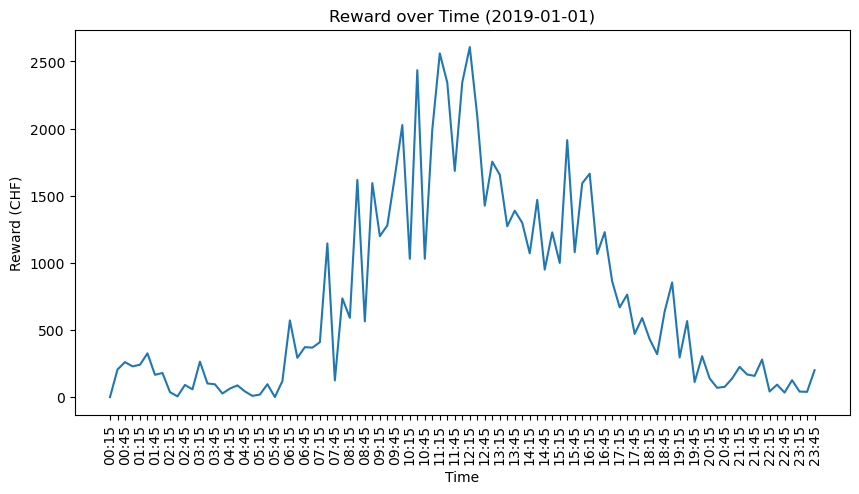

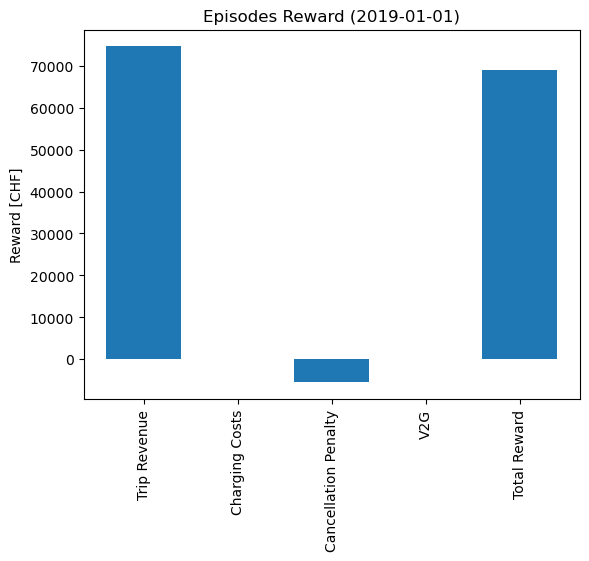

Total reward 2019-01-01:
69115.92718444631

Total Episode Time:  2.0210254192352295

Data loading:  0.0
Reward in this step: 59.25  time:  96
Reward in this step: 36.45  time:  97
Reward in this step: 0.0  time:  98
Reward in this step: 162.85000000000002  time:  99
Reward in this step: 50.8  time:  100
Reward in this step: 0.0  time:  101
Reward in this step: 58.400000000000006  time:  102
Reward in this step: 0.0  time:  103
Reward in this step: 12.5  time:  104
Reward in this step: 26.1  time:  105
Reward in this step: 30.5  time:  106
Reward in this step: 0.0  time:  107
Reward in this step: 14.98  time:  108
Reward in this step: 0.0  time:  109
Reward in this step: 0.0  time:  110
Reward in this step: 5.7  time:  111
Reward in this step: 59.17  time:  112
Reward in this step: 0.0  time:  113
Reward in this step: 0.0  time:  114
Reward in this step: 64.41  time:  115
Reward in this step: 36.2  time:  116
Reward in this step: 32.8  time:  117
Reward in this step: 202.4  time:  118
R

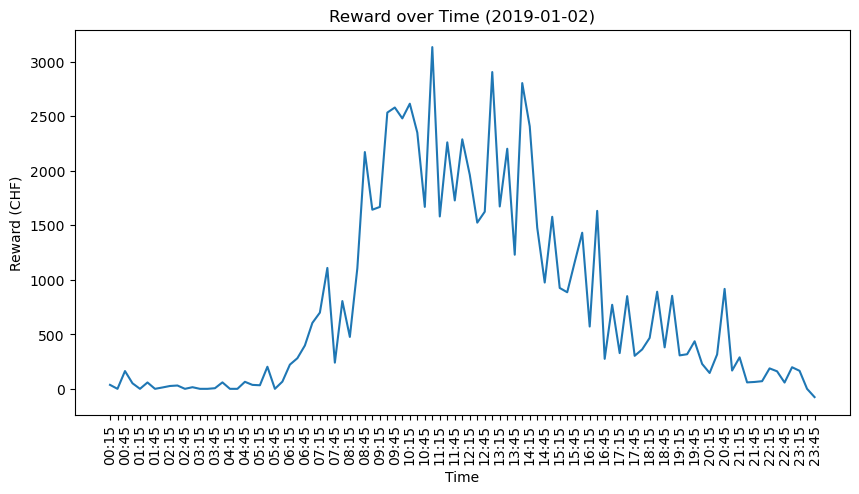

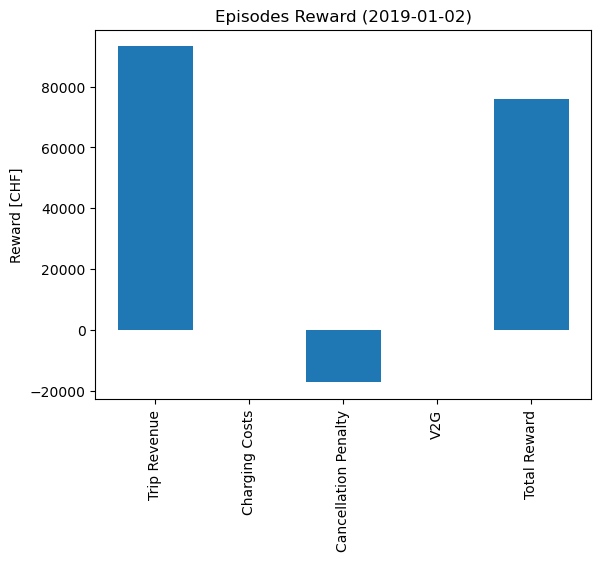

Total reward 2019-01-02:
75913.92918908314

Total Episode Time:  4.10383939743042

Data loading:  0.0
Reward in this step: 23.83  time:  192
Reward in this step: 64.2  time:  193
Reward in this step: 13.45  time:  194
Reward in this step: 134.15  time:  195
Reward in this step: 112.89  time:  196
Reward in this step: 0.0  time:  197
Reward in this step: 36.7  time:  198
Reward in this step: 0.0  time:  199
Reward in this step: -72.55  time:  200
Reward in this step: 14.71  time:  201
Reward in this step: 0.0  time:  202
Reward in this step: 0.0  time:  203
Reward in this step: 0.0  time:  204
Reward in this step: 9.55  time:  205
Reward in this step: -82.85  time:  206
Reward in this step: 133.79999999999998  time:  207
Reward in this step: 0.0  time:  208
Reward in this step: 20.65  time:  209
Reward in this step: 71.30545343701093  time:  210
Reward in this step: 105.7  time:  211
Reward in this step: 35.30000000000001  time:  212
Reward in this step: 38.4  time:  213
Reward in this 

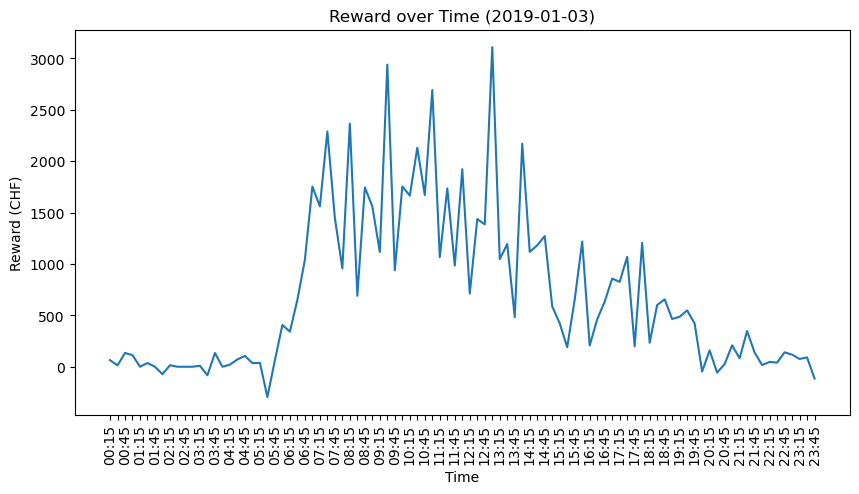

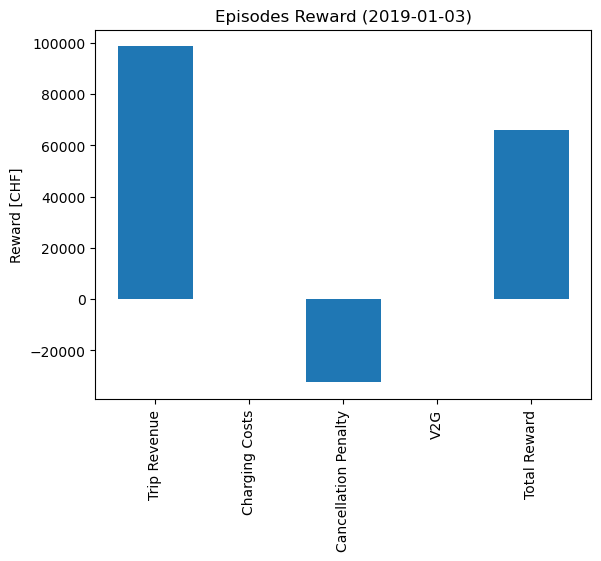

Total reward 2019-01-03:
66162.92891306088

Total Episode Time:  6.098229169845581

Data loading:  0.0
Reward in this step: 50.09  time:  288
Reward in this step: -0.269999999999996  time:  289
Reward in this step: -87.1  time:  290
Reward in this step: -22.556111689620565  time:  291
Reward in this step: -200.0  time:  292
Reward in this step: 48.0  time:  293
Reward in this step: 0.0  time:  294
Reward in this step: 4.5  time:  295
Reward in this step: -100.0  time:  296
Reward in this step: 0.0  time:  297
Reward in this step: -30.700000000000003  time:  298
Reward in this step: 0.0  time:  299
Reward in this step: 0.0  time:  300
Reward in this step: 21.35  time:  301
Reward in this step: -100.0  time:  302
Reward in this step: -154.1  time:  303
Reward in this step: -88.5  time:  304
Reward in this step: 9.6  time:  305
Reward in this step: 15.8  time:  306
Reward in this step: -26.429999999999993  time:  307
Reward in this step: 33.45  time:  308
Reward in this step: 122.25999999

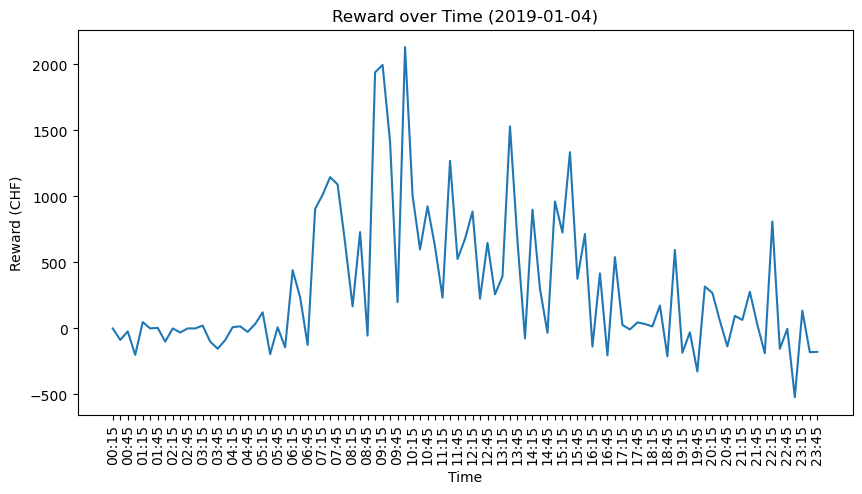

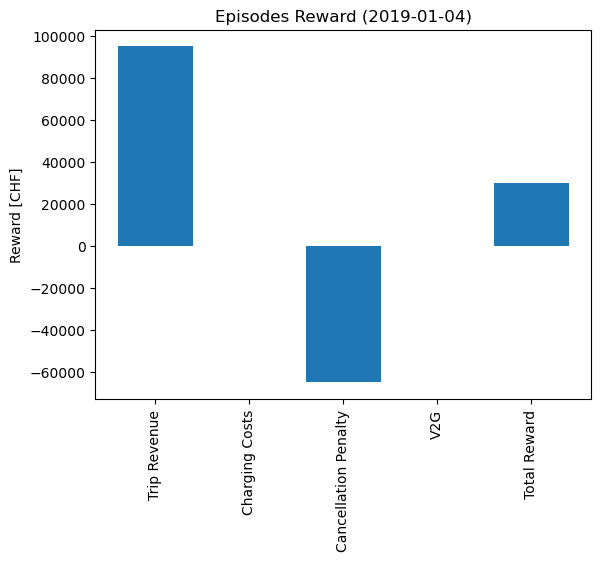

Total reward 2019-01-04:
30084.3535539625

Total Episode Time:  9.03028154373169

Data loading:  0.0
Reward in this step: 85.28000000000003  time:  384
Reward in this step: 153.57300701500378  time:  385
Reward in this step: 199.1744386094804  time:  386
Reward in this step: -69.7572784380268  time:  387
Reward in this step: -91.5  time:  388
Reward in this step: 0.0  time:  389
Reward in this step: 11.15  time:  390
Reward in this step: -26.8442430954144  time:  391
Reward in this step: 101.80000000000001  time:  392
Reward in this step: -100.0  time:  393
Reward in this step: 0.0  time:  394
Reward in this step: 0.0  time:  395
Reward in this step: 3.2988806637125947  time:  396
Reward in this step: 0.0  time:  397
Reward in this step: -82.6  time:  398
Reward in this step: -26.94999999999999  time:  399
Reward in this step: -121.41  time:  400
Reward in this step: 139.65166555824536  time:  401
Reward in this step: 173.26999999999998  time:  402
Reward in this step: -67.93  time:  4

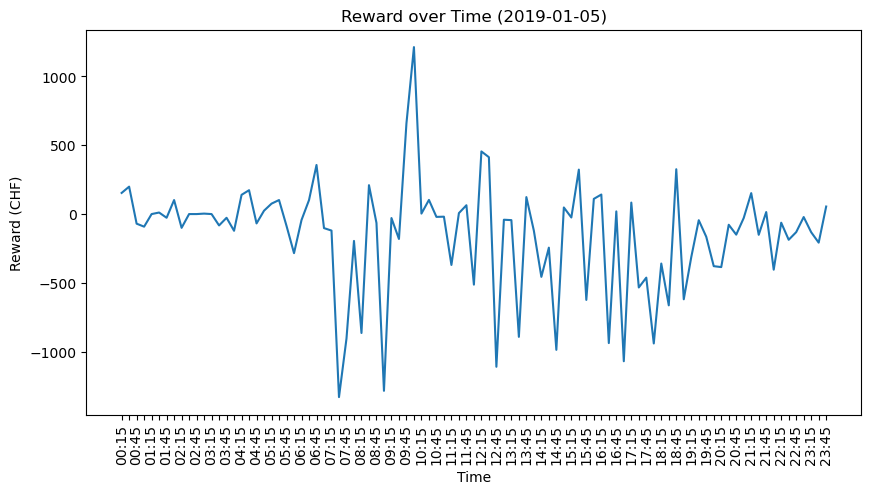

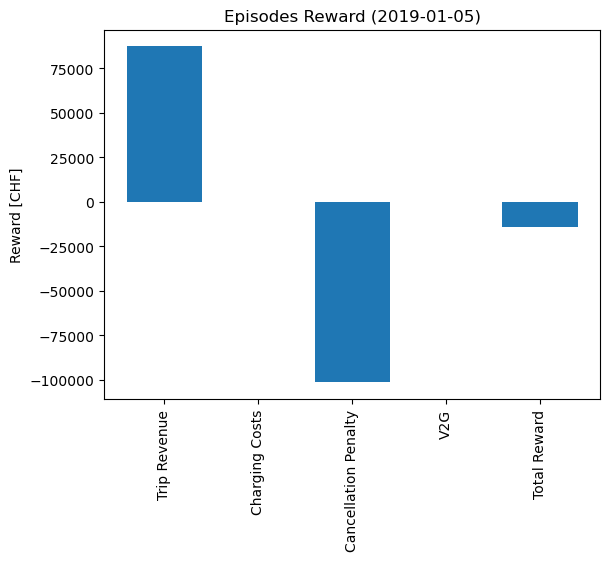

Total reward 2019-01-05:
-13992.915974137513

Total Episode Time:  11.979679584503174

Data loading:  0.0
Reward in this step: -41.75  time:  480
Reward in this step: -100.0  time:  481
Reward in this step: -186.38  time:  482
Reward in this step: -290.49833444175465  time:  483
Reward in this step: -233.2  time:  484
Reward in this step: -39.9806709203991  time:  485
Reward in this step: 56.7  time:  486
Reward in this step: 0.0  time:  487
Reward in this step: 13.650000000000006  time:  488
Reward in this step: 35.6  time:  489
Reward in this step: -202.7075907824982  time:  490
Reward in this step: -100.0  time:  491
Reward in this step: 10.15  time:  492
Reward in this step: 0.0  time:  493
Reward in this step: 45.7  time:  494
Reward in this step: -100.0  time:  495
Reward in this step: -70.0  time:  496
Reward in this step: -119.5690787782213  time:  497
Reward in this step: 0.0  time:  498
Reward in this step: -75.2  time:  499
Reward in this step: -100.0  time:  500
Reward in t

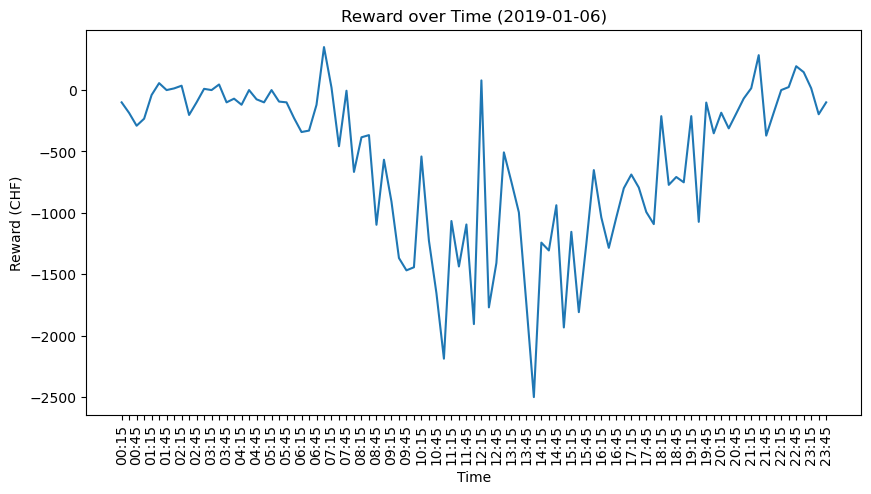

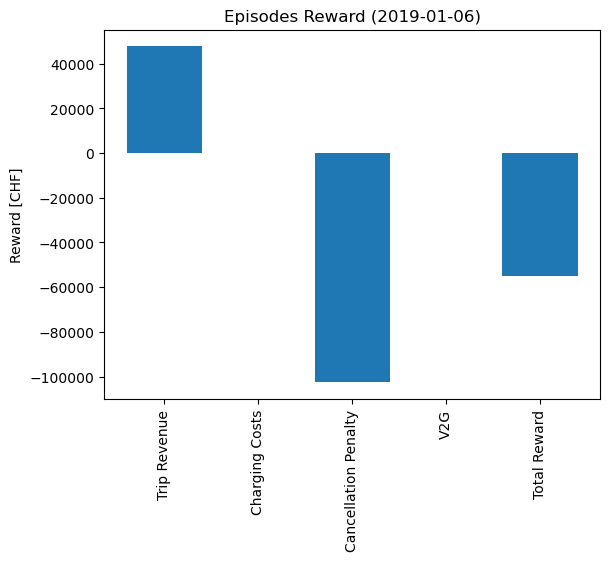

Total reward 2019-01-06:
-54882.79372870669

Total Episode Time:  10.755741834640503

Data loading:  0.0
Reward in this step: 89.47  time:  576
Reward in this step: -100.0  time:  577
Reward in this step: -150.1098827828539  time:  578
Reward in this step: -245.8  time:  579
Reward in this step: -171.51  time:  580
Reward in this step: 75.06  time:  581
Reward in this step: -100.0  time:  582
Reward in this step: 0.0  time:  583
Reward in this step: -87.5  time:  584
Reward in this step: 0.0  time:  585
Reward in this step: 15.3  time:  586
Reward in this step: 0.0  time:  587
Reward in this step: -100.0  time:  588
Reward in this step: -100.0  time:  589
Reward in this step: -93.15  time:  590
Reward in this step: 0.0  time:  591
Reward in this step: -100.0  time:  592
Reward in this step: -79.05  time:  593
Reward in this step: 0.0  time:  594
Reward in this step: -170.85  time:  595
Reward in this step: -130.30382871499026  time:  596
Reward in this step: -51.96  time:  597
Reward i

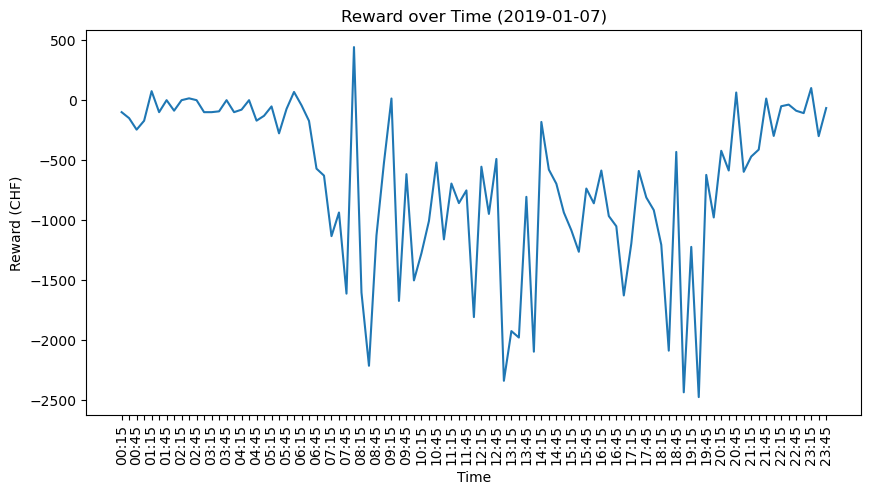

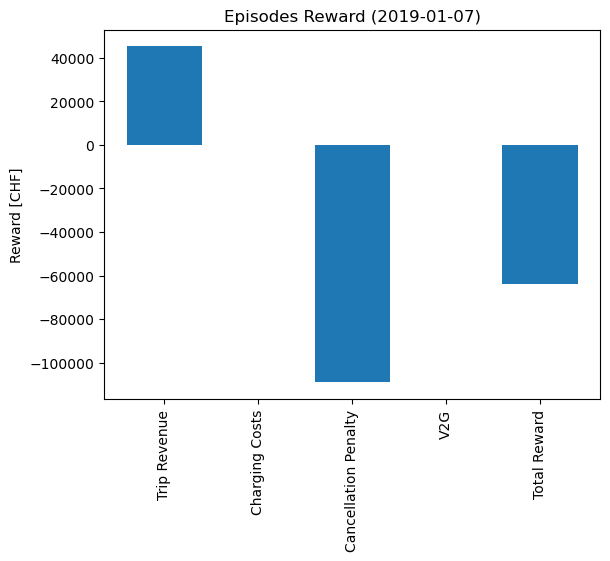

Total reward 2019-01-07:
-63801.15429446272

Total Episode Time:  11.065510272979736

Data loading:  0.0
Reward in this step: -86.9  time:  672
Reward in this step: -100.0  time:  673
Reward in this step: -100.0  time:  674
Reward in this step: -400.0  time:  675
Reward in this step: -100.0  time:  676
Reward in this step: 10.6  time:  677
Reward in this step: 0.0  time:  678
Reward in this step: 0.0  time:  679
Reward in this step: -200.0  time:  680
Reward in this step: 134.27086238792515  time:  681
Reward in this step: 0.0  time:  682
Reward in this step: 0.0  time:  683
Reward in this step: 0.0  time:  684
Reward in this step: 0.0  time:  685
Reward in this step: 46.7  time:  686
Reward in this step: -87.95  time:  687
Reward in this step: -300.0  time:  688
Reward in this step: 16.819999999999993  time:  689
Reward in this step: -200.0  time:  690
Reward in this step: 7.7  time:  691
Reward in this step: -122.9  time:  692
Reward in this step: -91.5  time:  693
Reward in this ste

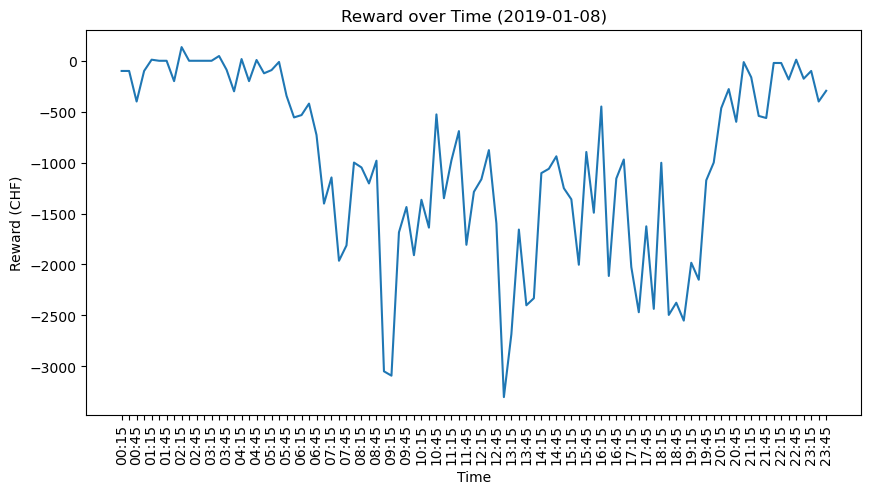

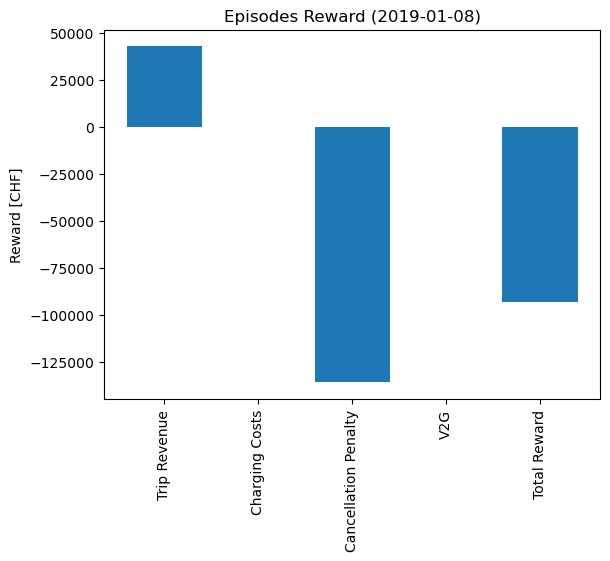

Total reward 2019-01-08:
-93343.07578724678


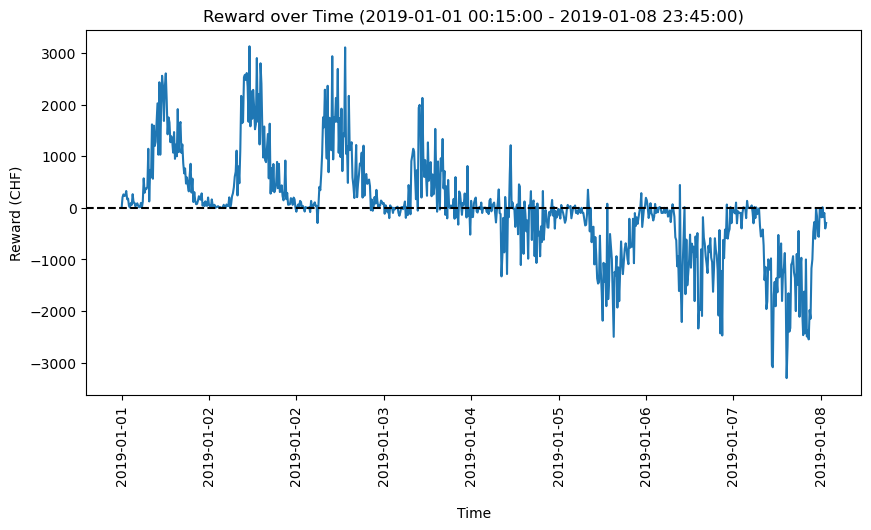

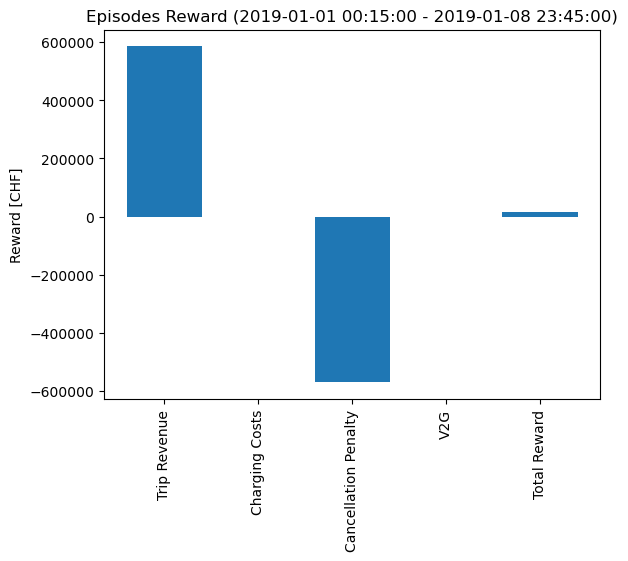

Total reward (2019-01-01 00:15:00 - 2019-01-08 23:45:00):
15436.46905599911

Total Episode Time:  12.433976411819458



In [41]:
# number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
env = CarsharingEnv(stations, vehicles, planned_bookings = True, plot_state_histogram = False, plot_state_animation = False, max_distance_car_assingment = 500, v2g_penalty = 0, v2g_reward=0, penalty_per_kwh = 0)
    
count = 0

# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        timesteps_since_start = count * 96
        start = time.time()
        start2 = time.time()
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        
        # load reservations
        reservations = reservations_dict[date_day.strftime('%Y-%m-%d')]
    
        end2 = time.time()
        print("Data loading: ", end2-start2)
        # get discete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        
        # reset day at begining of new episode (day)
        #s = env.reset(daily_data, reservations, timesteps_since_start, planned_reservations_day, planned_durations_day)
        
        if count == 0:
            s = env.reset(daily_data, reservations, timesteps_since_start, planned_reservations_day, planned_durations_day)
        else:
            env.get_random_v2g_events()
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, daily_data, done, _ = env.step(act, daily_data, reservations, electricity_price, timesteps_since_start, planned_reservations_day, planned_durations_day)
            
            
            
            print("Reward in this step:", rew, " time: ", env.t)
            counter +=1
        end = time.time()
        # summary statistics of episode (day)
        env.daily_summary_statistics()
        if count == nr_iterations - 1:
            env.episode_summary_statistics(nr_iterations)
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        count += 1